## Vision Transformers (ViTs) Using PyTorch

In this notebook, we will learn to build a PyTorch-based hybrid CNN and ViT for image classification. We will start by using CNN layers to extract detailed features, such as edges and textures, from images. Then, we will see how those features are passed to a ViT, which looks at the global correlations in the entire image by looking at all locations at once. Then, we will train a hybrid CNN-Vit model. 

1. Load the custom trained PyTorch CNN model
2. Extract features maps from the PyToch model
3. Prepare tokens for the Vision Transformer
4. Build the Vision Transformer ensoder
5. Train and evaluate the hybrid model

#### Step 1: Setup and importing libraties 

In [165]:
%%time
import warnings
warnings.filterwarnings('ignore')

import os
import time
import httpx
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

def present_time():
        return datetime.now().strftime('%Y%m%d_%H%M%S')


CPU times: total: 0 ns
Wall time: 26.9 μs


In [166]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
print("Imported PyTorch libraries")

Imported PyTorch libraries
CPU times: total: 0 ns
Wall time: 165 μs


##### Layout
- First, we load the pre-trained PyTorch based CNN model.
- Then, we define the CNN backbone. This is same as defined in the training of the pre-trained model.
- The CNN backbone reduces the input image's spatial dimensions and expands its feature channels. We then convert this feature map into a sequence of tokens for the ViT.
- These tokens are passd into a Vit module. The ViT is applied after the CNN so it can model global relationships and context between different regions in the original image, something CNNS alone cannot do as effectively. 
- We use a sequential hybrid architecture: the CNN performs local feature extraction, and the ViT, using those extracted features, performs global reasoning. This leverages the strengths of both models for improved accuracy and generalization. 
- Feature reshaping is used: the CNN feature map is flattened and fed into the transformer, and positional encoding might be added to preserve spatial information.
- We train this hybrid model end-to-end, meaning both the CNN and ViT parameters are updated together to optimize classification performance. 
- Throughout the process, we are able to monitor both local (CNN) and global (ViT) attention across the image, resulting in a model that is more robust and effective than using either approach.  

#### Step 2: Loading model paths

In [167]:
data_dir = "."

pytorch_state_dict_name = "ibm_ai_capstone_project.pth"
pytorch_state_dict_path = os.path.join(data_dir, pytorch_state_dict_name)

To achieve reproducible results when we train a CNN in PyTorch, we must seed every random-number generator and configures cuDNN dor deterministic kernels. 

- **Python & NumPy** - Many data-pipeline utilities (shuffling lists, image augmentations) rely on these random-number generators. Seeding them first removes one entire layer of randomness. 
- **PyTorch CPU / GPU** - `torch.manual_seed` covers every op executed on the CPU, while `torch.cuda.manual_seed_all` applies the same seed to each GPU stream so that multi-GPU jobs stay in sync. 
- **cuDNN flags** - By default cuDNN picks the fastes convolution algorithm, which can vary run-to-run. Setting `deterministic = True` forces repeatable kernels and turning `benchmark` *off* prevents the auto-tuner from replaceing those kernels mid-training. 

In [168]:
def set_seed(seed: int = 42) -> None:
    """Seed Python, NumPy, and PyTorch (CPU & all GPUs) and 
    make cuDNN run in deterministic mode."""
    
    # PyTorch and NumPy
    random.seed(seed)
    np.random.seed(seed)

    # PyTorch (CPU & GPU)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # cuDNN: force repeatable convolutions
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [169]:
SEED = 7331
set_seed(SEED)
print(f"Global seed set to {SEED} - main process is now deterministc.")

Global seed set to 7331 - main process is now deterministc.


#### Step 3: Defining pre-trained CNN backbone

We shall create and implement a **ConvNet** class. This class serves as the convolutional backbone for the hybrid CNN-ViT architecture. The design of this class will be **same as training architecture**, with six progressive convolutional blocks. 
- `forward_features()`: Returns the raw convolutional feature map (B, 1024, H, W) for use by the ViT component
- **Role in hybrid architecture**: In the hybrid model, this CNN serves as a local feature extractors, capturing low-level patterns, edges, and textures before passing the feature-rich representation to the ViT for global context modeling. The 1024-channels output provides a rich semantic representation that the ViT can process as a sequence of tokens.

In [170]:
class ConvNet(nn.Module):
    '''
    Class to define the architecture same as the imported pre-trained CNN model for extracting the feature map
    '''

    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(32),

            # Conv Block 2-6
            nn.Conv2d(32, 64, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(512),
            nn.Conv2d(512, 1024, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(1024),
        )

    def forward_features(self, x):
        return self.features(x)

#### Step 4: Vision Transformers

##### Patch embedding

The **PatchEmbed** class implements the **interface** between the CNN feature extractor and the Vit, converting spatial feature maps into a sequence of tokens suitable for self-attention processing.

Unlike traditional ViT implementations that divide raw images into fixed-size patches, this hybrid approach operates on CNN feature maps. The implementation uses a 1 x 1 convolution as a learned linear projection to transform the 1024-dimensional CNN features into the transformer's embedding dimension (default 768).

The transformation process involves 3 key steps:
1. **Channel projection**: `nn.Conv2d(in_ch, embed_dim, kernel_size=1)` reduces or expands the channel dimension from 1024 to the preferred embedding size.
2. **Spatial flattening**: `.flatten(2)` collapses the height and width dimensions (HxW) into a single sequence dimension
3. **Tensor reshaping**: `.transpose(1,2)` reorders dimensions from (B, D, L) to (B, L, D) where L = H x W represents the sequence length

**Integration with hybrid architecture**
In the contect of the hybrid model, this patch embedding serves as the bridge between local CNN features and global transformer processing. Since the CNN has already extracted meaningful local patterns, the patch embedding focuses on format conversion rather than feature extraction. This deisgn is more **efficient** than traditional ViT patch embedding since the CNN has already performed the heavy lifting of feature extraction from raw pixels. 

The **output tensor** (B, L, D) represents a batch of sequences where each sequence contains L tokens (corresponding to spatial locations in the feature map) with D-dimensional embddings ready for transformer processing. 

In [171]:
class PatchEmbed(nn.Module):
    def __init__(self, input_channel = 1024, embed_dim = 768):
        super().__init__()
        self.proj = nn.Conv2d(input_channel, embed_dim, kernel_size=1) # 1 x 1 conv
    
    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1,2) # (B,L,D)
        return x

#### Step 5: Multi-head self-attention (MHSA) module

The MHSA class implements the self-attention mechanism that enables the ViT to model long-range dependencies and global context across all spatial locations in the feature map.

The implementation follows the scaled dot-product attention formula: **Attention (Q, K, V) = softmax(QK^T/√d)V**, where Q, K, and V represent query key, and value metrices, respectively. The scaling factor 1/√d prevents the dot products from becoming too large, which would push the softmac function into regions with extremely small gradients. 

The multi-head mechanism splits the embedding dimension across multiple attention heads, allowing the model to attend to different types of relationship simultaneously. 

Key implementation details: 
- Unified QKV projection: A single linear layer `nn.Linear(dim, dim*3)` generates Q, K, and V matrices efficiently, reducing memoty overhead compared to seperate projections. 
- Head reshaping: The tensor is reshaped from (B, N, D) to (H, heads, N, d) where d = D/heads, enabling parallel processing across heads.
- Attention computation: Matric multiplication `torch.matmul(q, k.transpose(-2, -1))` computes attention scores, followed by scaling and softmax normalization. 
- Dropout regularization: Two dropout layers prevent overfitting - one on attention weights and one on the final output.

Unlike CNNs, which have limited receptive fields, self-attention allows every token to interact directly with every other token in a single operation. This enables the model to capture **long-range spatial dependencies** that might be missed by purely convolutional approaches.

In the hybrid architecture, this global modeling complements the local feature extraction performd by the CNN backbone. 

The attention weights provide interpretability, showing which spatial locations the model focuses on when making predictions. This component is valuable for both performance and explainability. 

In [172]:
class MHSA(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x):
        B, N, D = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.reshape(B, N, self.heads, -1).transpose(1, 2) # B, heads, N, d
        k = k.reshape(B, N, self.heads, -1).transpose(1, 2)
        k = k.reshape(B, N, self.heads, -1).transpose(1, 2)
        v = v.reshape(B, N, self.heads, -1).transpose(1, 2)
        attn = torch.matmul(q, k.transpose(-2, -1) * self.scale)
        attn = self.attn_drop(attn.softmax(dim=-1))
        x = torch.matmul(attn, v).transpose(1, 2).reshape(B, N, D)
        return self.proj_drop(self.proj(x))

#### Step 6: Transformer block

This code defines a building block used in modern deep learning models, especially in ViT. The class is called TransformerBlock, and it is responsible for helping the model "pay attention" to the most important parts of its input and improve the final predictions.

What actually happens inside:

**Layer normalization (nn.LayerNorm)**: This helps stabilize and speed up training by normalizing each row of the input data, which is useful before applying attention or a neural network layer.

**Attention later (MHSA)**: This is the "Multi-Head Self Attention" block. It enables the model to look at all positions in the sequence (or image patches) at once, figuring out which ones are most important for each output. It is like giving the model the power to focus on the key parts of an image or sentence. 

**MLP (nn.Sequential)**: This is a Multi-Layer Perception or a mini neural network, made up of linear (fully connected) layers, a special activation (GELU), and dropout for regularization. This MLP has:
- One linear layer that expands the input dimension by mlp_ratio (for example, 4x wider).
- A GELU activation function (a nonlinear operation, similar to ReLU).
- Dropout for regularization (helps prevent overfitting).
- Another linear layer that shrinks the data back to the original dimension.
- Another dropout layer. Here MLP is designed to help the model learn better representations by combining and transforming the information after the attention step.

**Skip/Residual connection (x + ...):** These connections support effective and stable training for deep neural network by keeping pathways open for both forward information flow and backward gradient flow, making depp architectures such as transformers possible and practical. In transformers, skip connections are placed around both the attention and feedforward (MLP) sub-layers in each block. This stabalizes training of these very deep, stackable models, improves convergence speed, and lets them scale to larger dataset and more complex tasks.

In summary, this block helps models understand relationships in their input data, making them more powerful for tasks such as image and language understanding.

In [173]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_ratio = 4, dropout = 0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MHSA(dim, heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(), 
            nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

#### Step 7: ViT model

Thhe ViT class represents the complete ViT inplementation, including patch embedding, positional encoding, transformer blocks, and a classification head for global context modeling. 

The implementation uses a leanable Classification (CLS) token:
- Initialization: `nn.Parameter(torch.zeros(1,1, embed_dim))` creates a learnable token initialized to zeros 
- Expansion: `self.cls.expand(B, -1, -1)` replicares the token across the batch dimension
- Prepending: `torch.cat((cls, x), 1)` concatenates the CLS token to the beginning of the sequence 
- Classification: Only the CLS token representation is used for final classification

This allows the CLS token to aggreate information from all spatial locations through self-attention, creating a global representation suitable for classification.

`nn.Parameter(torch.randn(1, max_tokens, embed_dim))` creates a large positional embedding matric and `self.pos[:, :L+1]` dynamically slices the positional embeddings to match the actual sequence length. Together, these create a **dynamic positional encoding** system for the hybrid architecture where the CNN feature map size can vary based on input dimensions. 

`depth` defines the number of transformerBlocks to be used in the transformer encoder.

###### Classification head design

The final classification pipeline includes: 
1. **Final normalization**: `self.norm(x)` applies LayerNorm to the final transformer output.
2. **CLS token extraction**: `[:, 0]` selects only the CLS token representation
3. **Linear classification**: `self.head` maps the CLS representation to the class logits

The model's ability to handle variable sequence lengths makes it robust to different input sizes and CNN architectures, prociving flexibility in deployment scenratios.

In [174]:
class ViT(nn.Module):
    def __init__(self, in_ch=1024, num_classes=2, embed_dim=768, depth=6, heads=8, mlp_ratio=4., dropout=0.1, max_tokens=50):
        super().__init__()
        self.patch = PatchEmbed(in_ch, embed_dim) # 1 x 1 conv
        self.cls = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos = nn.Parameter(torch.randn(1, max_tokens, embed_dim))
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):                        # x: (B,C,H,W)
        x = self.patch(x)                        # (B, L, D)
        B, L, _ = x.shape                        
        cls = self.cls.expand(B, -1, -1)         # (B, 1, D)
        x = torch.cat((cls, x), 1)               # (B, L+1, D)
        x = x + self.pos[:, :L + 1]              # match seq-len
        for blk in self.blocks:
            x = blk(x)
        return self.head(self.norm(x)[:, 0])     # CLS token

#### Step 8: CNN-ViT hybrid model

The CNN_ViT_Hybrid class represents the hybrid architecture, integrating the CNN backbone with the Vision Transformer to create a unified model that leverages both local and global feature processing capabilities. In this hybrid model, the pre-trained CNN layers can be frozen while fine-tuning the ViT and allows for efficient attention to operate on semantically rich CNN features rather than raw pixel. Thus, this hybrid approach combines the excellent capabilities of CNN to capture local patterns efficiently with ViT's global context modeling, while keeping the level of complexity low. 

The forward pass implements a two-stage forward pass pipeline:
1. **Local feature extraction**: `self.cnn.forward_features(x)` processes the input image through the CNN backbone, extracting hierarchical local features and reducing spatial resolution while increasing semantic depth.
2. **Global context modeling**: `self.vit(features)` takes the CNN feature map and processes it through the ViT for global reasoning and classificaiton.

Despite te modeular design, the entire hybrid model remains fully differentiable, enabling the end-to-end training where gradients could flow from the classification loss back through both the ViT and CNN components. This allows the CNN to learn features that are optimally suited for the downstream transformer processing, creating a synergetic relationship between the two architectures. 

In [175]:
class CNN_ViT_Hybrid(nn.Module):
    def __init__(self, num_classes = 2, embed_dim = 768, depth = 6, heads = 8):
        super().__init__()
        self.cnn = ConvNet(num_classes)
        self.vit = ViT(
            num_classes=num_classes,
            embed_dim = embed_dim,
            depth = depth,
            heads = heads
            )
    
    def forward(self, x):
        return self.vit(self.cnn.forward_features(x))

#### Step 9: Model training

The train function implements a comprehensive training loop for one epoch, handling forward propagation, loss computation, backpropagation, and metric tracking in a memory-efficient manner.

Training mode: The function begins with `model.train`, which configures the model for training by enabling dropout layers and gradient computation. 

Batch processing pipeline: Each training iteration follows a standard deep learning pipeline:
1. **Data transfer**: `x, y = x.to(device), y.to(device)` moves input data and labels to the appropriate device (CPU/GPU)
2. **Gradient reset**: `optimizer.zero_grad()` clears gradients from the previous iteration to prevent accumulation 
3. **Forward pass**: `out = model(x)` computes predictions through the hybrid CN-ViT architecture 
4. **Loss computation**: `loss = criterion(out, y)` calculates cross-entropy loss between predictions and ground truth
5. **Backpropagation**: `loss.backward()` computes gradients via automatic differentiation.
6. **Parameter update**: `optimizer.step()` updates model parameters using the computed gradients.

Metrics accumulation: The function tracks two key metrics:
- **Weighted loss**: `loss.item() * x.size(0)` accumulates loss weighted by batch size for accurate aceraging
- **Correct predictions**: `(out.argmax(1) == y).sum().item()` counts correct predictions using argmax for multi-class classification

In [185]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    loss_sum, correct = 0, 0
    for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Training ")):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)

#### Step 10: Model evaluation

Here, we wil evaluate the model, implementing inference without gradient computation to optimize memory usage and computational speed.

Two fundamental differences between using the model for evaluation and testing versus training are:
  - **torch.no_grad()**: Disables gradient computation and accelerate inference
  - **model.eval()**: Switches the model to evaluation mode, esnures deterministic outputs

The **evaluation loop** mirrors the training loop structure but omits gradient-related operations.

This function **integrates with the training pipeline**, providing regular validation checks that help monitor model progress, detect overfitting, and make informed decisions about training continuation, learning rate adjustements, and model selection. The consisten interface with the training function enables easy integration into automated training workflows.

In [187]:
def evaluate(model, loader, criterion, device):
    with torch.no_grad():
        model.eval()
        loss_sum, correct = 0, 0
        for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Validation")):
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)

#### Step 11: Data preparation and loading

Here, we implement data preparation for the entire data pipeline, from raw image loading to batches tensor delivery.

We define the key training hyperparameters:
- **Image size (64 x 64)**: Chosen to computational efficiency while maintaining sufficient resolution for feature extraction. 
- **Batch size (128)**: Balances memory usage with gradient stability and training speed.
- **learning rate (0.001)**: A conservative number for learning
- **number of classes**: Total number of classes to be classified by the model

In [188]:
dataset_path = os.path.join(data_dir, "images_dataSAT")

img_size = 64
batch_size = 32
lr = 0.001
num_cls = 2

#### Step 12: Training and validation data transformations

The **training transform** pipeline implements several augmentation techniques including Random Rotation, Random Horizontal Flip, Random Affine with Shear and normalization.

In [189]:
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # It normalizes the image so each RGB channel matches the mean and standard deviation of ImageNet images, making pixel values roughly centered around 0 with unit variance.
])

In [190]:
val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # It normalizes the image so each RGB channel matches the mean and standard deviation of ImageNet images, making pixel values roughly centered around 0 with unit variance.
])

#### Step 13: The DataLoader

The DataLoader setup is optimized for training:
- Shuffling: Training data is shuffled to prevent batch-level patterns
- No Clidation Shuffling: Validation order is consistent for reproducible results
- `batch_size`: Efficient tensor batching for GPU utilization

We begin by splitting the dataset into `training` and `validation` data using `random_split` feature. Here, we define 80% of the total dataset for training and rest for validation.

Next, we apply the `train_transform` to `train_dataset` and `val_transform` to `val_dataset` to make the dataset ready for DataLoader

In [191]:
full_dataset = datasets.ImageFolder(dataset_path, transform=train_transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_dataset.dataset.transform = train_transform 
val_dataset.dataset.transform = val_transform

In [192]:
train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True,
)

In [193]:
val_loader = DataLoader(
    val_dataset, 
    batch_size = batch_size,
    shuffle = False
)

#### Step 14: Model initialization and training loop

This cell orchestrates the complete training pipeline, from model's instantiation through iterative training and validation, implementing comprehensive monitoring and logging for effective model development.

- **CUDA detection**: `torch.cuda.is_available()` checks for GPU availability

The hybrid model is instantiated with carefully chosen hyperparameters:
- **Number of classes**: `num_classes = 2` configured for the specific dataset
- **Default architecture**: Uses ViT configuration (768 embedding dim, 1 transformer layer, 1 heads)

Transfer learning integration 
The commented line demonstrates transfer learning capability:
- **Pre-trained weights**: Option to load pre-trained CNN backbone weights
- **Flexibile loading**: `strict = False` allows partial weight loading. 

**Optimizer**: The training uses `adam` optimizer. 

The training loop collects the **training and validation metrics** to track training performance and monitor generalization of the model.

##### Training loop architecure
Each rpoch follows a standard pipeline:
1. Timing: `time.time()` tracks epoch duration for performance monitoring
2. Training phase: Calls the training function with appropriate parameters 
3. Validation phase: Evaluates model on validation set
4. Logging: Comprehensive output showing all metrics and timing
5. Storage: Appends metrics to tracking lists for later analysis

In this training cell, we create a robust, monitored, and efficient training pipeline that provides comprehensive insights into model performance while maintaining computational efficiency enabling easy debugging and optimization.

In [198]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training the model on {device}")

epochs = 5
attn_heads = 6
depth = 3
embed_dim = 768

print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")

model_dict_name = f"ai_capstone_pytorch_vit_model_state_dict.pth"

model = CNN_ViT_Hybrid(
    num_classes=num_cls,
    heads=attn_heads,
    depth=depth,
    embed_dim=embed_dim
).to(device)

# ------------------------------------------------------------------------------------------#
# LOADING PRE-TRAINED CNN MODEL WEIGHTS
model.cnn.load_state_dict(torch.load(pytorch_state_dict_path), strict=False)
# ------------------------------------------------------------------------------------------#
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

best_loss = float('inf')
tr_loss_all = []
te_loss_all = []
tr_acc_all = []
te_acc_all = [] 

training_time = []

for epoch in range(1, epochs+1):
    start_time = time.time()
    print(f"\nEpoch {epoch: 02d}/{epochs:02d} started at {present_time()}")
    tr_loss, tr_acc = train(model, train_loader, optimizer, criterion, device) # Former gets the loss, latter gets the acc (just the way it is)
    te_loss, te_acc = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {te_loss:.4f} acc {te_acc:.4f} |"
          f" in  {time.time()-start_time:.02f}s"
        )
    tr_loss_all.append(tr_loss)
    te_loss_all.append(te_loss)
    tr_acc_all.append(tr_acc)
    te_acc_all.append(te_acc)
    training_time.append(time.time() - start_time)

    # save the best model
    avg_te_loss = te_loss
    if avg_te_loss < best_loss:
        print(f"Current loss ({avg_te_loss:.04f}) lower than previous best loss ({ best_loss:.04f}), Saving current model state")
        best_loss = avg_te_loss
        torch.save(model.state_dict(), model_dict_name)
        
print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")


Training the model on cuda
epochs:5 | batch:32 | attn_heads:6 | depth:3 | embed_dim:768

Epoch  1/05 started at 20251025_204938


Validation: 100%|██████████| 38/38 [00:00<00:00, 49.33it/s]


Epoch 01 | train loss 0.2340 acc 0.9481 | val loss 0.0569 acc 0.9833 | in  7.50s
Current loss (0.0569) lower than previous best loss (inf), Saving current model state

Epoch  2/05 started at 20251025_204945


Validation: 100%|██████████| 38/38 [00:00<00:00, 46.83it/s]


Epoch 02 | train loss 0.0904 acc 0.9740 | val loss 0.0363 acc 0.9900 | in  7.71s
Current loss (0.0363) lower than previous best loss (0.0569), Saving current model state

Epoch  3/05 started at 20251025_204953


Validation: 100%|██████████| 38/38 [00:00<00:00, 49.06it/s]


Epoch 03 | train loss 0.0959 acc 0.9683 | val loss 0.0229 acc 0.9925 | in  7.44s
Current loss (0.0229) lower than previous best loss (0.0363), Saving current model state

Epoch  4/05 started at 20251025_205001


Validation: 100%|██████████| 38/38 [00:00<00:00, 49.36it/s]


Epoch 04 | train loss 0.1085 acc 0.9650 | val loss 0.0457 acc 0.9833 | in  7.33s

Epoch  5/05 started at 20251025_205008


Validation: 100%|██████████| 38/38 [00:00<00:00, 48.39it/s]

Epoch 05 | train loss 0.0624 acc 0.9808 | val loss 0.0356 acc 0.9900 | in  7.32s
epochs:5 | batch:32 | attn_heads:6 | depth:3 | embed_dim:768


#### Step 15: Optimize model

### Hyperparameter cheatsheet (depth based)

The Depth of the transformer blocks signify the number of transformer blocks stacked in the model. This is one of the most important features which differentiates a ViT from CNN.

This table proides a basic overview on **how depth affects** other hyperparameters and model performance.

|  **Depth** | **Attention heads** | **Dataset Size** |  **Performance** | **learning rate** | **Feature Complexity** | **Learning Focus** |
|:---:|:---:|---|:---:|---|:---|:---:|
| **3** | 6 | size < 1000 | Underfitting - too shallow |0.001 (Shallow: can handle higher learning rates) | Low-level features | Edges, textures, basic patterns |
| **6** | 6 | size <1000 | Good for simple tasks |0.001 (Shallow: can handle higher learning rates) | Mid-level features | Shapes, object parts, spatial relationships |
| **12** | 12 | 1000 < size < 10000 | Standard choice - good balance | 0.0005 (Medium: moderate learning rate) | High-level features | Objects, semantic concepts, global context |
| **18** | 12 | 10000 < size < 100000 | High performance on complex tasks | 0.0003 (Deep: lower learning rate for stability) | High-level features | Objects, semantic concepts, global context |
| **24** | 16 | 100000 < size | Diminishing returns, overfitting risk | 0.0001 (Very deep: very small learning rate) | High-level features | Objects, semantic concepts, global context |
| **36** | 16 | 100000 < size | Likely overkill for most tasks | 0.0001 (Very deep: very small learning rate) | High-level features | Objects, semantic concepts, global context |


In [202]:
print(len(full_dataset))

6000


In [207]:
device   = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training the model on {device}")

epochs = 5
attn_heads = 12
depth = 12
embed_dim = 768

print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")

model_dict_name = f"ai_capstone_pytorch_vit_model_test_state_dict"

model_test = CNN_ViT_Hybrid(
    num_classes=num_cls,
    heads = attn_heads,
    depth = depth,
    embed_dim = embed_dim
).to(device)

model_test.cnn.load_state_dict(torch.load(pytorch_state_dict_path), strict=False)

criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model_test.parameters(), lr=lr)

best_loss = float("inf")
tr_loss_all_test = []
te_loss_all_test =  []
tr_acc_all_test = []
te_acc_all_test = []

training_time = []

for epoch in range(1, epochs+1):
    start_time = time.time()
    print(f"\nEpoch {epoch:02d}/{epochs:02d} started at {present_time()}")
    tr_loss_test, tr_acc_test = train(model_test, train_loader, optimizer, criterion, device)
    te_loss_test, te_acc_test = evaluate(model_test, val_loader, criterion, device)
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss_test:.4f} acc {tr_acc_test:.4f} | "
          f"val loss {te_loss_test:.4f} acc {te_acc_test:.4f} |"
          f" in  {time.time()-start_time:.02f}s"
        )
    tr_loss_all_test.append(tr_loss_test)
    te_loss_all_test.append(te_loss_test)
    tr_acc_all_test.append(tr_acc_test)
    te_acc_all_test.append(te_acc_test)
    training_time.append(time.time() - start_time)

    avg_te_loss = te_loss_test
    if avg_te_loss < best_loss:
        print(f"Current loss ({avg_te_loss:.04f}) lower than previous best loss ({ best_loss:.04f}), Saving current model state")
        best_loss = avg_te_loss
        torch.save(model_test.state_dict(), model_dict_name)

print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")




Training the model on cuda
epochs:5 | batch:32 | attn_heads:12 | depth:12 | embed_dim:768

Epoch 01/05 started at 20251025_210043


Validation: 100%|██████████| 38/38 [00:01<00:00, 37.08it/s]


Epoch 01 | train loss 0.1651 acc 0.9577 | val loss 0.0133 acc 0.9967 | in  13.54s
Current loss (0.0133) lower than previous best loss (inf), Saving current model state

Epoch 02/05 started at 20251025_210057


Validation: 100%|██████████| 38/38 [00:01<00:00, 35.81it/s]


Epoch 02 | train loss 0.0848 acc 0.9752 | val loss 0.0118 acc 0.9942 | in  13.82s
Current loss (0.0118) lower than previous best loss (0.0133), Saving current model state

Epoch 03/05 started at 20251025_210111


Validation: 100%|██████████| 38/38 [00:01<00:00, 35.58it/s]


Epoch 03 | train loss 0.0705 acc 0.9773 | val loss 0.0313 acc 0.9917 | in  13.82s

Epoch 04/05 started at 20251025_210125


Validation: 100%|██████████| 38/38 [00:01<00:00, 36.12it/s]


Epoch 04 | train loss 0.0726 acc 0.9760 | val loss 0.0853 acc 0.9792 | in  13.74s

Epoch 05/05 started at 20251025_210139


Validation: 100%|██████████| 38/38 [00:01<00:00, 35.81it/s]


Epoch 05 | train loss 0.0505 acc 0.9831 | val loss 0.0107 acc 0.9967 | in  13.63s
Current loss (0.0107) lower than previous best loss (0.0118), Saving current model state
epochs:5 | batch:32 | attn_heads:12 | depth:12 | embed_dim:768


#### Step 16: Plotting training and validation accuracy and loss


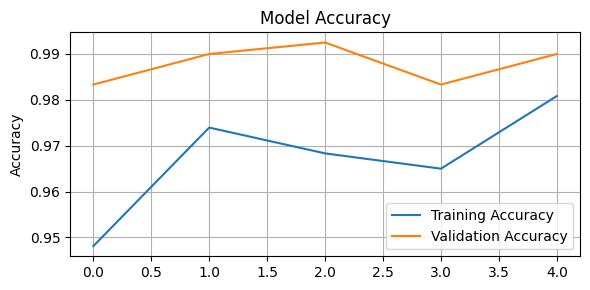

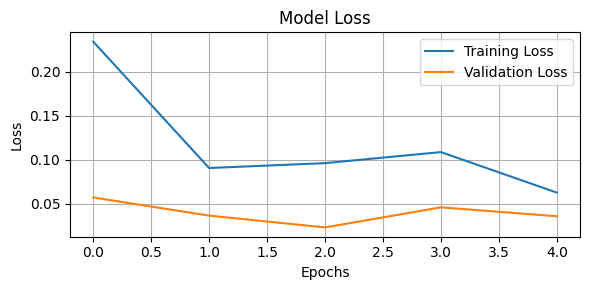

In [211]:
fig_w, fig_h = 6, 3
fig, axs = plt.subplots(figsize=(fig_w, fig_h))

# Plot Accuracy on the first subplot
axs.plot(tr_acc_all, label="Training Accuracy")
axs.plot(te_acc_all, label="Validation Accuracy")
axs.set_title("Model Accuracy")
axs.set_ylabel("Accuracy")
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(figsize=(fig_w, fig_h))

# Plot loss on the second subplot
axs.plot(tr_loss_all, label="Training Loss")
axs.plot(te_loss_all, label="Validation Loss")
axs.set_title("Model Loss")
axs.set_xlabel("Epochs")
axs.set_ylabel("Loss")
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

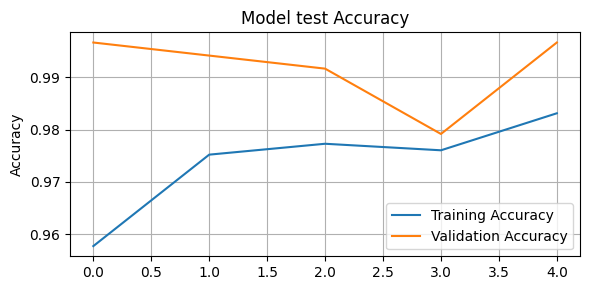

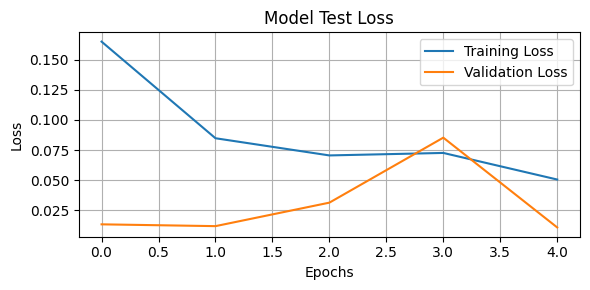

In [212]:
fig_w, fig_h = 6, 3
fig, axs = plt.subplots(figsize=(fig_w, fig_h))

# Plot Accuracy on the first subplot
axs.plot(tr_acc_all_test, label="Training Accuracy")
axs.plot(te_acc_all_test, label="Validation Accuracy")
axs.set_title("Model test Accuracy")
axs.set_ylabel("Accuracy")
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(figsize=(fig_w, fig_h))

# Plot loss on the second subplot
axs.plot(tr_loss_all_test, label="Training Loss")
axs.plot(te_loss_all_test, label="Validation Loss")
axs.set_title("Model Test Loss")
axs.set_xlabel("Epochs")
axs.set_ylabel("Loss")
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

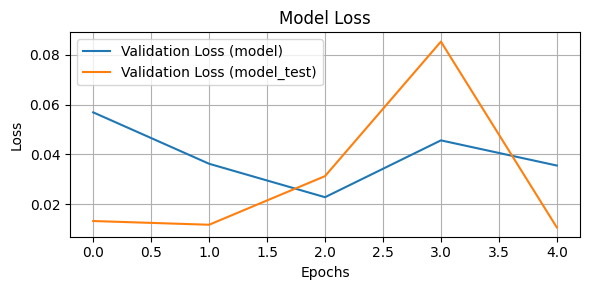

In [213]:
## Please use the space below to write your answer
fig, axs = plt.subplots( figsize=(fig_w, fig_h ))

# Plot Loss on the second subplot
axs.plot(te_loss_all, label='Validation Loss (model)')
axs.plot(te_loss_all_test, label='Validation Loss (model_test)')
axs.set_title('Model Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

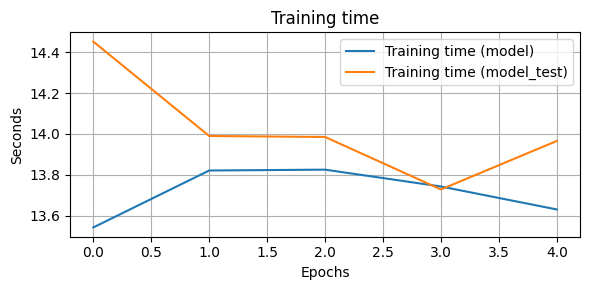

In [214]:
fig, axs = plt.subplots( figsize=(fig_w, fig_h ))

# Plot Loss on the second subplot
axs.plot(training_time, label='Training time (model)')
axs.plot(training_time_test, label='Training time (model_test)')
axs.set_title('Training time')
axs.set_xlabel('Epochs')
axs.set_ylabel('Seconds')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()